# Przewidywanie wynagrodzenia data scientist
### Opis projektu
Projekt ten może pomóc w wyborze kariery zawodowej osobie, której zależy na pieniądzach :)\
Po wybraniu zawodu, waluty, kraju model pokaże przewidywane wynagrodzenie.\
Dataset źródłowy: https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries \
Dataset pomocniczy z PKP per capita: https://www.kaggle.com/datasets/zgrcemta/world-gdpgdp-gdp-per-capita-and-annual-growths?select=gdp_per_capita.csv \
W powyższym datasetcie można znaleźć takie dane jak, rok w którym wypłacono wynagrodzenie, doświadczenie, forme zatrudnienia, zawód, wynagrodzenie, walutę wynagrodzenia, wynagrodzenie w przeliczeniu na dolary, miejsce zamieszkania pracownika, stosunek pracy zdalnej do stacjonarnej, lokalizacja firmy i wielkość firmy.\
Dataset ma około 600 rekordów.
Do przewidywania wynagrodzenia użyję regresji liniowej. Model będzie ewaluowany za pomocą:\
Mean Absolute Error – sprawdza średni błąd predykcji\
Root Mean Squared Error -  podobnie do MAE, ale jest bardziej wyczulony na nierównomiernie rozkład różnicy błędów\
Coefficient of determination (R- squared) – miara stopnia w jakim model pasuje do próby \

In [ ]:
# podłączenie do dysku google
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import bibliotek
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
#import pycountry
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sb

In [ ]:
# wczytanie, wgląd w pierwsze rekordy
df = pd.read_csv('/content/drive/MyDrive/ds_salaries.csv')
df.head(10)

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
5,5,2020,EN,FT,Data Analyst,72000,USD,72000,US,100,US,L
6,6,2020,SE,FT,Lead Data Scientist,190000,USD,190000,US,100,US,S
7,7,2020,MI,FT,Data Scientist,11000000,HUF,35735,HU,50,HU,L
8,8,2020,MI,FT,Business Data Analyst,135000,USD,135000,US,100,US,L
9,9,2020,SE,FT,Lead Data Engineer,125000,USD,125000,NZ,50,NZ,S


In [ ]:
df.columns

Index(['Unnamed: 0', 'work_year', 'experience_level', 'employment_type',
       'job_title', 'salary', 'salary_currency', 'salary_in_usd',
       'employee_residence', 'remote_ratio', 'company_location',
       'company_size'],
      dtype='object')

Zestaw danych zawiera 11 kolumn (+ indeks):
1. work_year - rok w który zapłacono to wynagrodzenie.
2. experience_level - poziom doświadczenia pracownika.
3. employment_type - typ zatrudnienia.
4. job_title - stanowisko/nazwa zawodu.
5. salary - roczne wynagrodzenie brutto.
6. salary_currency - waluta podanego wynagrodzenia.
7. salary_in_usd - roczne wynagrodzenie brutto przeliczone na dolary.
8. employee_residence - kod kraju rezydowania pracownika.
9. remote_ratio - jaka część (w procentach) pracy była pracą zdalną.
10. company_location: kod kraju w którym zlokalizowana jest firma.
11. company_size: rozmiar firmy

Które ze zmiennych są najbardziej skorelowane z wynagrodzeniem?

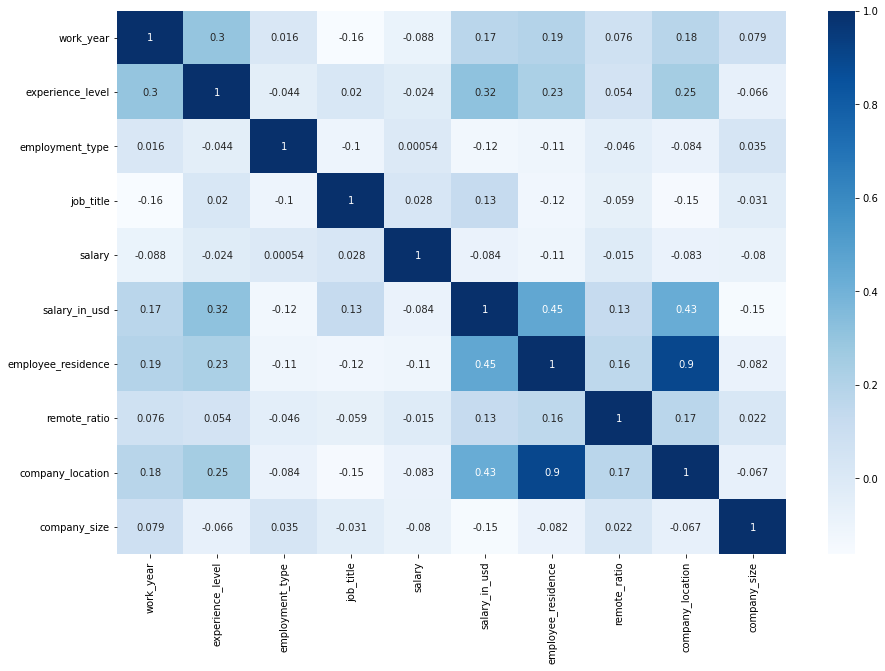

In [ ]:
dfcorr=df.drop(df.columns[0], axis=1)
dfcorr['work_year']=dfcorr['work_year'].astype('category').cat.codes
dfcorr['experience_level']=df['experience_level'].astype('category').cat.codes
dfcorr['employment_type']=df['employment_type'].astype('category').cat.codes
dfcorr['job_title']=df['job_title'].astype('category').cat.codes
dfcorr['employee_residence']=df['employee_residence'].astype('category').cat.codes
dfcorr['company_location']=df['company_location'].astype('category').cat.codes
dfcorr['company_size']=df['company_size'].astype('category').cat.codes
corr = dfcorr.corr()
fig, ax = plt.subplots(figsize=(15,10))
sb.heatmap(corr, cmap="Blues", annot=True)

## Czy w zestawie danych istnieją brakujące wartości, błędy danych itp.?
Wybór kolumn i czyszczenie danych

In [ ]:
df.isna().any()

Unnamed: 0            False
work_year             False
experience_level      False
employment_type       False
job_title             False
salary                False
salary_currency       False
salary_in_usd         False
employee_residence    False
remote_ratio          False
company_location      False
company_size          False
dtype: bool

### Sprawdzenie wartości unikalnych

In [ ]:
print('work_year:',df['work_year'].unique())

work_year: [2020 2021 2022]


Dane pochodzą z lat 2020-2022

In [ ]:
print('experience_level:',df['experience_level'].unique())

experience_level: ['MI' 'SE' 'EN' 'EX']


Skróty te mogą nie być łatwe do rozszyfrowania, ale w tym pomoże opis tego zestawu danych na kaggle'u:\
EN: Entry-level / Junior\
MI: Mid-level / Intermediate\
SE: Senior-level / Expert\
EX: Executive-level / Director

In [ ]:
print('employment_type:',df['employment_type'].unique())

employment_type: ['FT' 'CT' 'PT' 'FL']


FT: Full time\
CT: Contract\
PT: Part Time\
FL: Freelance

In [ ]:
print('job_title:',df['job_title'].unique())

job_title: ['Data Scientist' 'Machine Learning Scientist' 'Big Data Engineer'
 'Product Data Analyst' 'Machine Learning Engineer' 'Data Analyst'
 'Lead Data Scientist' 'Business Data Analyst' 'Lead Data Engineer'
 'Lead Data Analyst' 'Data Engineer' 'Data Science Consultant'
 'BI Data Analyst' 'Director of Data Science' 'Research Scientist'
 'Machine Learning Manager' 'Data Engineering Manager'
 'Machine Learning Infrastructure Engineer' 'ML Engineer' 'AI Scientist'
 'Computer Vision Engineer' 'Principal Data Scientist'
 'Data Science Manager' 'Head of Data' '3D Computer Vision Researcher'
 'Data Analytics Engineer' 'Applied Data Scientist'
 'Marketing Data Analyst' 'Cloud Data Engineer' 'Financial Data Analyst'
 'Computer Vision Software Engineer' 'Director of Data Engineering'
 'Data Science Engineer' 'Principal Data Engineer'
 'Machine Learning Developer' 'Applied Machine Learning Scientist'
 'Data Analytics Manager' 'Head of Data Science' 'Data Specialist'
 'Data Architect' 'Financ

Znajduje się tu duża liczba unikalnych nazw stanowisk. Na podstawie liczby rekordów dla każdego stanowiska zostaną wybrane te, z najmniejszą liczbą obserwacji, które zastąpie popularniejszymi nazwami.

In [ ]:
df.groupby(['job_title']).size().sort_values(ascending=True) 

job_title
3D Computer Vision Researcher                 1
NLP Engineer                                  1
Marketing Data Analyst                        1
Machine Learning Manager                      1
Lead Machine Learning Engineer                1
Head of Machine Learning                      1
Finance Data Analyst                          1
Data Specialist                               1
Data Analytics Lead                           1
Staff Data Scientist                          1
Big Data Architect                            1
Director of Data Engineering                  2
ETL Developer                                 2
Cloud Data Engineer                           2
Principal Data Analyst                        2
Financial Data Analyst                        2
Product Data Analyst                          2
Machine Learning Infrastructure Engineer      3
Data Science Engineer                         3
Lead Data Scientist                           3
Lead Data Analyst             

In [ ]:
clean_df = df.drop(df.columns[0], axis=1)

Nadmiarowy indeks został usunięty

In [ ]:
clean_df = clean_df.replace('3D Computer Vision Researcher', 'Computer Vision Engineer')
clean_df = clean_df.replace('NLP Engineer', 'Machine Learning Engineer')
clean_df = clean_df.replace('Marketing Data Analyst', 'Data Analyst')
clean_df = clean_df.replace('Machine Learning Manager', 'Machine Learning Engineer')
clean_df = clean_df.replace('Lead Machine Learning Engineer', 'Machine Learning Engineer')
clean_df = clean_df.replace('Head of Machine Learning', 'Machine Learning Engineer')
clean_df = clean_df.replace('Finance Data Analyst', 'Data Analyst')
clean_df = clean_df.replace('Data Specialist', 'Data Analyst')
clean_df = clean_df.replace('Data Analytics Lead', 'Data Analyst')
clean_df = clean_df.replace('Staff Data Scientist', 'Data Scientist')
clean_df = clean_df.replace('Big Data Architect', 'Big Data Engineer')
clean_df = clean_df.replace('Director of Data Engineering', 'Big Data Engineer')
clean_df = clean_df.replace('ETL Developer', 'Data Engineer')
clean_df = clean_df.replace('Cloud Data Engineer', 'Data Engineer')
clean_df = clean_df.replace('Principal Data Analyst', 'Data Analyst')
clean_df = clean_df.replace('Financial Data Analyst', 'Data Analyst')
clean_df = clean_df.replace('Product Data Analyst', 'Data Analyst')
clean_df = clean_df.replace('Machine Learning Infrastructure Engineer', 'Machine Learning Engineer')
clean_df = clean_df.replace('Data Science Engineer', 'Data Scientist')
clean_df = clean_df.replace('Lead Data Scientist', 'Data Scientist')
clean_df = clean_df.replace('Lead Data Analyst', 'Data Analyst')
clean_df = clean_df.replace('Computer Vision Software Engineer', 'Computer Vision Engineer')
clean_df = clean_df.replace('Principal Data Engineer', 'Data Engineer')
clean_df = clean_df.replace('Machine Learning Developer', 'Machine Learning Engineer')
clean_df = clean_df.replace('Analytics Engineer', 'Data Scientist')
clean_df = clean_df.replace('Data Analytics Engineer', 'Data Scientist')
clean_df = clean_df.replace('Applied Machine Learning Scientist', 'Machine Learning Scientist')
clean_df = clean_df.replace('Head of Data Science', 'Data Scientist')
clean_df = clean_df.replace('Data Engineering Manager', 'Data Engineer')
clean_df = clean_df.replace('Applied Data Scientist', 'Data Scientist')
clean_df = clean_df.replace('Head of Data Science', 'Data Scientist')
clean_df = clean_df.replace('Business Data Analyst', 'Data Analyst')
clean_df = clean_df.replace('Head of Data', 'Data Scientist')
clean_df = clean_df.replace('BI Data Analyst', 'Data Analyst')
clean_df = clean_df.replace('ML Engineer', 'Machine Learning Engineer')
clean_df = clean_df.replace('Lead Data Engineer', 'Data Engineer')
clean_df = clean_df.replace('Director of Data Science', 'Data Scientist')
clean_df = clean_df.replace('Data Science Consultant', 'Data Scientist')
clean_df = clean_df.replace('Principal Data Scientist', 'Data Scientist')
clean_df = clean_df.replace('AI Scientist', 'Machine Learning Engineer')
clean_df = clean_df.replace('Data Analytics Manager', 'Data Analyst')
clean_df = clean_df.replace('Head of Data', 'Data Scientist')
clean_df = clean_df.replace('Head of Data', 'Data Scientist')
clean_df = clean_df.replace('Head of Data', 'Data Scientist')
clean_df = clean_df.replace('Head of Data', 'Data Scientist')
clean_df = clean_df.replace('Head of Data', 'Data Scientist')
clean_df = clean_df.replace('Head of Data', 'Data Scientist')

clean_df.groupby(['job_title']).size().sort_values(ascending=True) 

job_title
Computer Vision Engineer       10
Big Data Engineer              11
Data Architect                 11
Data Science Manager           12
Machine Learning Scientist     12
Research Scientist             16
Machine Learning Engineer      64
Data Analyst                  128
Data Engineer                 150
Data Scientist                193
dtype: int64

Uwaga: przy uogólnianiu niestety traci na "pełnym obrazie". Zamiana, m.in "Lead Data Engineer", "Director of Data Engineering", "Data Analytics Manager" na tytuły "szeregowego" pracownika może w pierwszym momencie wydawać się myląca, ale należy pamiętać o kolumnie "experience_level". Osoba o profilu, np. analityk danych w ten sposób może się dowiedzieć jakie zarobki będzie w stanie osiągnąć, gdyby osiągnęła stanowisko dyrektora.

In [ ]:
clean_df = clean_df.drop(columns=['salary', 'salary_currency'])

Istotne dla analizy pod kątem szacowania wysokości wynagrodzenia, jest to by było ono w tej samej walucie. Kwota w walucie lokalnej + kod waluty nie jest ważny w tej analizie.

In [ ]:
conditions = [
    (clean_df['experience_level'] == 'EN'),
    (clean_df['experience_level'] == 'MI'),
    (clean_df['experience_level'] == 'SE'),
    (clean_df['experience_level'] == 'EX')
]
values = [1, 2, 3, 4]

clean_df['experience_level_no.'] = np.select(conditions, values)
clean_df = clean_df.drop(columns=['experience_level'])

Jaka forma kontraktu ma średnio najwyższe dochody?

In [ ]:
grouped_df = clean_df.groupby(['employment_type']).mean().reset_index().sort_values(by=['salary_in_usd'])
fig = px.bar(grouped_df, x='employment_type', y='salary_in_usd')
fig.show()

In [ ]:
conditions = [
    (clean_df['employment_type'] == 'PT'),
    (clean_df['employment_type'] == 'FL'),
    (clean_df['employment_type'] == 'FT'),
    (clean_df['employment_type'] == 'CT')
]
values = [1, 2, 3, 4]

clean_df['employment_type_no.'] = np.select(conditions, values)
clean_df = clean_df.drop(columns=['employment_type'])

In [ ]:
conditions = [
    (clean_df['company_size'] == 'S'),
    (clean_df['company_size'] == 'M'),
    (clean_df['company_size'] == 'L')
]
values = [1, 2, 3]

clean_df['company_size_no.'] = np.select(conditions, values)
clean_df = clean_df.drop(columns=['company_size'])
clean_df

,work_year,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,experience_level_no.,employment_type_no.,company_size_no.
0,2020,Data Scientist,79833,DE,0,DE,2,3,3
1,2020,Machine Learning Scientist,260000,JP,0,JP,3,3,1
2,2020,Big Data Engineer,109024,GB,50,GB,3,3,2
3,2020,Data Analyst,20000,HN,0,HN,2,3,1
4,2020,Machine Learning Engineer,150000,US,50,US,3,3,3
...,...,...,...,...,...,...,...,...,...
602,2022,Data Engineer,154000,US,100,US,3,3,2
603,2022,Data Engineer,126000,US,100,US,3,3,2
604,2022,Data Analyst,129000,US,0,US,3,3,2
605,2022,Data Analyst,150000,US,100,US,3,3,2


In [ ]:
grouped_df = clean_df.groupby(['company_location']).mean().reset_index().sort_values(by=['salary_in_usd'])
fig = px.bar(grouped_df, x='company_location', y='salary_in_usd')
fig.show()

Widać różnice średnich zarobków na podstawie krajów. Ostatecznie zestaw danych zostaje ograniczony do USA, ze względu na negatywny wpływ różnych krajów na przewidywanie

In [ ]:
# clean_df['company_location']=clean_df['company_location'].astype('category').cat.codes
clean_df = clean_df[clean_df['company_location']=='US']
clean_df = clean_df.drop(columns=['company_location'])
clean_df = clean_df.drop(columns=['employee_residence'])

Różnice między latami nie są duże

In [ ]:
clean_df = clean_df.drop(columns=['work_year'])

Przekonwertowanie kolumny ze stringami nazw zawodów na szereg kolumn boolean:

In [ ]:
clean_df = pd.get_dummies(clean_df
               ,columns = ['job_title']
               ,drop_first = True
               )

Aby przewidywane wartości były liczbami całkowitymi użyje konwersji do inta.

In [ ]:
clean_df['salary_in_usd'] = clean_df['salary_in_usd'].astype(int)

## Ostateczny zestaw danych wygląda tak:

In [ ]:
clean_df

,salary_in_usd,remote_ratio,experience_level_no.,employment_type_no.,company_size_no.,job_title_Computer Vision Engineer,job_title_Data Analyst,job_title_Data Architect,job_title_Data Engineer,job_title_Data Science Manager,job_title_Data Scientist,job_title_Machine Learning Engineer,job_title_Machine Learning Scientist,job_title_Research Scientist
4,150000,50,3,3,3,0,0,0,0,0,0,1,0,0
5,72000,100,1,3,3,0,1,0,0,0,0,0,0,0
6,190000,100,3,3,1,0,0,0,0,0,1,0,0,0
8,135000,100,2,3,3,0,1,0,0,0,0,0,0,0
13,87000,100,2,3,3,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,154000,100,3,3,2,0,0,0,1,0,0,0,0,0
603,126000,100,3,3,2,0,0,0,1,0,0,0,0,0
604,129000,0,3,3,2,0,1,0,0,0,0,0,0,0
605,150000,100,3,3,2,0,1,0,0,0,0,0,0,0


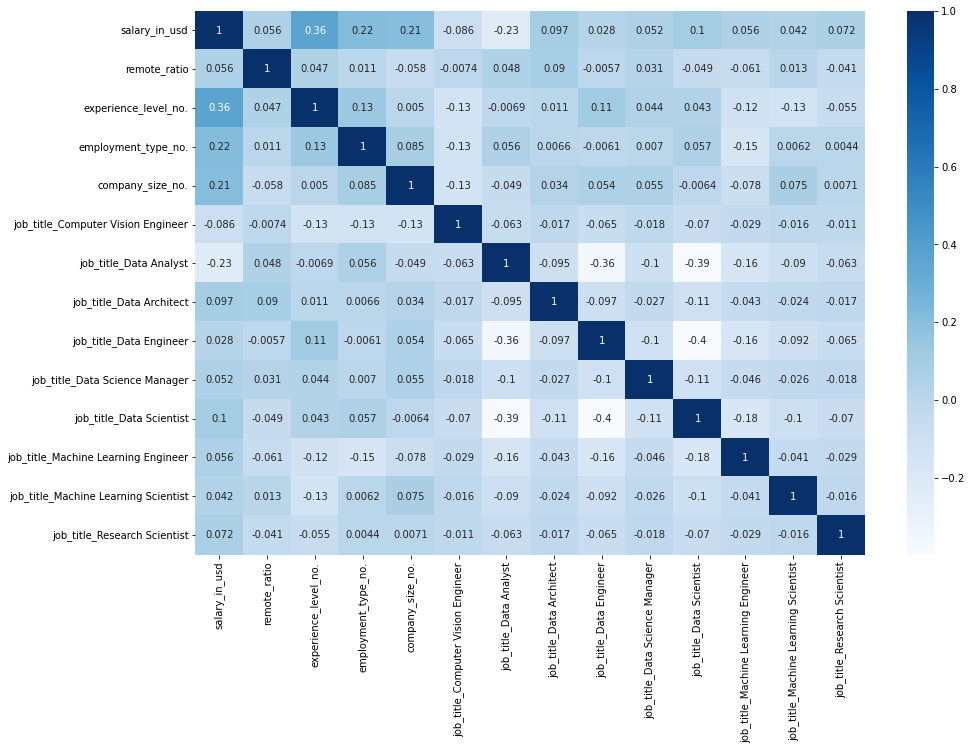

In [ ]:
corr = clean_df.corr()
fig, ax = plt.subplots(figsize=(15,10))
sb.heatmap(corr, cmap="Blues", annot=True)

##Modelowanie i ewaluacja

In [ ]:
model = LinearRegression()

def train_and_predict(dataset):
  y = dataset['salary_in_usd']
  X = dataset.drop(columns=['salary_in_usd'])
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

  model.fit(X_train, y_train)

  # Make predictions using the testing set
  y_pred = model.predict(X_test)

  # The mean squared error
  print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
  # The coefficient of determination: 1 is perfect prediction
  print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))


train_and_predict(clean_df)

Mean squared error: 3069763068.91
Coefficient of determination: 0.17


Obecnie wyniki są dosyć losowe

Usunięte zostaną wartości odstające

In [ ]:
df_filtered = pd.DataFrame()

for column in clean_df:
  if 'job_title_' in column:
    filtered_rows = clean_df[clean_df[column]==1]

    q_low = filtered_rows['salary_in_usd'].quantile(0.25)
    q_hi  = filtered_rows['salary_in_usd'].quantile(0.75)

    df_filtered = df_filtered.append(filtered_rows[(filtered_rows['salary_in_usd'] < q_hi) & (filtered_rows['salary_in_usd'] > q_low)])



for x in df_filtered['experience_level_no.'].unique():
  filtered_rows2 = df_filtered[df_filtered['experience_level_no.']==x]

  q_low = filtered_rows['salary_in_usd'].quantile(0.25)
  q_hi  = filtered_rows['salary_in_usd'].quantile(0.75)

  df_filtered2 = df_filtered.append(filtered_rows[(filtered_rows['salary_in_usd'] < q_hi) & (filtered_rows['salary_in_usd'] > q_low)])  


train_and_predict(df_filtered2)

Mean squared error: 248999764.05
Coefficient of determination: 0.64


# Podsumowanie

In [ ]:
input_frame = pd.DataFrame({'remote_ratio': [0, 50, 100, 50, 50, 50, 50],
                  'experience_level_no.': [1, 1, 1, 2, 2, 2, 2],
                  'employment_type_no.': [3, 3, 3, 3, 3, 3, 4],
                  'company_size_no.': [2, 2, 2, 2, 3, 2, 3],
                  'job_title_Computer Vision Engineer': [0, 0, 0, 0, 0, 0, 0],
                  'job_title_Data Analyst': [0, 0, 0, 0, 0, 0, 0],
                  'job_title_Data Architect': [0, 0, 0, 0, 0, 0, 0],
                  'job_title_Data Engineer': [0, 0, 0, 0, 0, 0, 0],
                  'job_title_Data Science Manager': [0, 0, 0, 0, 0, 0, 0],
                  'job_title_Data Scientist': [1, 1, 1, 1, 1, 1, 1],
                  'job_title_Machine Learning Engineer': [0, 0, 0, 0, 0, 0, 0],
                  'job_title_Machine Learning Scientist': [0, 0, 0, 0, 0, 0, 0],
                  'job_title_Research Scientist': [0, 0, 0, 0, 0, 0, 0]
                   }
                  )

input_frame['predicted_salary'] = model.predict(input_frame)
input_frame['predicted_salary'] = input_frame['predicted_salary'].astype(int)
input_frame

,remote_ratio,experience_level_no.,employment_type_no.,company_size_no.,job_title_Computer Vision Engineer,job_title_Data Analyst,job_title_Data Architect,job_title_Data Engineer,job_title_Data Science Manager,job_title_Data Scientist,job_title_Machine Learning Engineer,job_title_Machine Learning Scientist,job_title_Research Scientist,predicted_salary
0,0,1,3,2,0,0,0,0,0,1,0,0,0,126082
1,50,1,3,2,0,0,0,0,0,1,0,0,0,123991
2,100,1,3,2,0,0,0,0,0,1,0,0,0,121899
3,50,2,3,2,0,0,0,0,0,1,0,0,0,136219
4,50,2,3,3,0,0,0,0,0,1,0,0,0,136252
5,50,2,3,2,0,0,0,0,0,1,0,0,0,136219
6,50,2,4,3,0,0,0,0,0,1,0,0,0,150545


### Przegląd paru przypadków na podstawie przewidywań modelu:
- Praca junior data scientist jest najlepiej płatna gdy pracuje się stacjonarnie.\
- W wypadku "mida" przy takich samych parametrach, gdzie jedyna różnica to wielkość przedsiębiorstwa, nieznacznie więcej zaraobi pracujący w dużej korporacji.
- Senior data scientist zarobi znacznie więcej na kontrakcie niż umowie o prace na pełen etat

Wybrany przeze mnie model sprawdza sie dobrze w przewidywaniu wynagrodzenia, ale do wytrenowania potrzebuje odpowiedniego przekroju danych. Sądzę, że mając do wiekszej liczby danych przewidywani byłyby znacznie bardziej precyzyjne.